In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%pylab
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


# Hand Laterality Judgement

To examine whether Third Thumb usage leads to changes in body image, participants were presented with drawings of hand outlines, and asked to decide whether the hand drawings corresponded to a right or a left hand. Participants were instructed to respond verbally by indicating the hand laterality (left or right) of each presented image as fast as possible, while maintaining high accuracy. The stimuli included drawings of left and 4 right hands, presented in four different postures and at 7 different angles. 

Participants completed four experimental blocks, each including all of the 56 hand images. Time from the start of the image display to voice onset was recorded as the participants’ reaction time (RT). 

Here we analyse the recorded RTs and accuracy metrics too see if Third Thumnb training resulted in any changes too the visual hand laterality judgement.


In [2]:
subjects = ['SF1', 'SF2', 'SF3', 'SF4', 'SF5', 'SF6', 'SF7', 'SF8', 'SF11', 'SF12', 'SF13', 'SF14', 'SF15', 'SF16', 
            'SF17', 'SF19', 'SF21', 'SF22']
noFam = 3 # 3 participants did not complete the familiarisation session 

### Calculate mean RTs and accuracy

Accuracy is computed as the proportion of correct response of all valid trials. Only trials with correct responses are then included in the RT analysis. All RTs are also logarithmically transformed in order to correct for the skewed distribution and to satisfy the conditions for parametric statistical testing. Finally, transformed RTs deviating more than 3 standard deviations from the participants’ means (separately for each session) are discarded (outliers).

In [ ]:
STD_THRESH = 3

allRaw = pd.DataFrame()
allMean = pd.DataFrame()
allMeanLog = pd.DataFrame()
allProc = pd.DataFrame()
allProcTot = pd.DataFrame()

for subj in subjects:
    
    if (subj == 'SF2') or (subj == 'SF7') or (subj == 'SF17'):
        session = [1,2]
    else:
         session = [0,1,2]
    
    for sess in session:

        # read in the file
        if sess == 0:
            filename = "/Volumes/ritd-ag-project-rd00k9-tmaki67/" + subj + "/Familiarisation/HLJ/" + subj + "-fam-HLJ.csv"
        elif sess == 1:
            filename = "/Volumes/ritd-ag-project-rd00k9-tmaki67/" + subj + "/Pre/HLJ/" + subj + "-pre-HLJ.csv"
        elif sess == 2:
            filename = "/Volumes/ritd-ag-project-rd00k9-tmaki67/" + subj + "/Post/HLJ/" + subj + "-post-HLJ.csv"
        df = pd.read_csv(filename)
        
        # get rid of missing/noisy trials (marked by answer == 99 or rt < 0.3s; verified offline by hand)
        df['ANSWER'] = df['ANSWER'].replace(99,np.nan)
        df[pd.to_numeric(df['RT']) < 0.3] = np.nan
        df = df.dropna()
        
        # add accuracy, subject and session information
        df = df.assign(ACC=(df['HAND']) == (df['ANSWER']), SUBJ=subj, SESSION=sess)
        
        # append unprocessed data to one big dataframe
        allRaw = allRaw.append(df)
        
        # log transform the reaction times
        df['RT_LOG'] = np.log(df['RT'])
        
        # calculate mean accuracy per hand
        acc = df.groupby(['HAND'])['ACC'].mean()
        # calculate mean accuracy across hands
        total_acc = df['ACC'].mean()
        
        # calculate mean RT for the correct trials
        rt = df.loc[df['ACC']==1].groupby(['HAND'], as_index=False)['RT_LOG'].agg(['mean', 'std'])
        df = df.loc[df['ACC']==1].join(rt, on=['HAND'])
        # calculate mean RT across both hands
        total_rt = df.loc[df['ACC']==1]['RT_LOG'].agg(['mean','std'])
        
        # Exclude RTs that are above X STDs from mean and recompute mean RTs
        rt_filtered = df.loc[np.abs(df[df['ACC']==1]['RT_LOG'] - df['mean']) <= (STD_THRESH * df['std'])].groupby(['HAND'])['RT'].mean()
        total_rt_filtered = df.loc[np.abs(df[df['ACC']==1]['RT_LOG'] - total_rt['mean']) <= (STD_THRESH * total_rt['std'])]['RT'].mean()
        rt_log_filtered = df.loc[np.abs(df[df['ACC']==1]['RT_LOG'] - df['mean']) <= (STD_THRESH * df['std'])].groupby(['HAND'])['RT_LOG'].mean()
        total_rt_log_filtered = df.loc[np.abs(df[df['ACC']==1]['RT_LOG'] - total_rt['mean']) <= (STD_THRESH * total_rt['std'])]['RT_LOG'].mean()
        
        allProc = allProc.append(df.loc[np.abs(df[df['ACC']==1]['RT_LOG'] - df['mean']) <= (STD_THRESH*df['std'])])
        allProcTot = allProcTot.append(df.loc[np.abs(df[df['ACC']==1]['RT_LOG'] - total_rt['mean']) <= (STD_THRESH*total_rt['std'])])
        allMean = allMean.append([[subj, *rt_filtered, *acc, total_rt_filtered, total_acc, sess]])
        allMeanLog = allMeanLog.append([[subj, *rt_log_filtered, *acc, total_rt_log_filtered, total_acc, sess]])

        # Logging dropped trials
        print(subj + " " + str(sess) + ": " + str([df.loc[np.abs(df[df['ACC']==1]['RT_LOG'] - df['mean']) > (STD_THRESH * df['std'])]['RT'].count()]) + " trials above " + str(STD_THRESH) + " stds from mean")

allMeanLog.columns = ['SUBJ', 'RT_LEFT', 'RT_RIGHT', 'ACC_LEFT', 'ACC_RIGHT', 'RT_TOTAL', 'ACC_TOTAL', 'SESSION']
allMeanLog = allMeanLog.set_index('SUBJ')
allMean.columns = ['SUBJ', 'RT_LEFT', 'RT_RIGHT', 'ACC_LEFT', 'ACC_RIGHT', 'RT_TOTAL', 'ACC_TOTAL', 'SESSION']
allMean = allMean.set_index('SUBJ')
allRaw['logRT'] = np.log(allRaw['RT'])

### Raw logRT distribution plots

Text(0,0.5,'log(RT)')

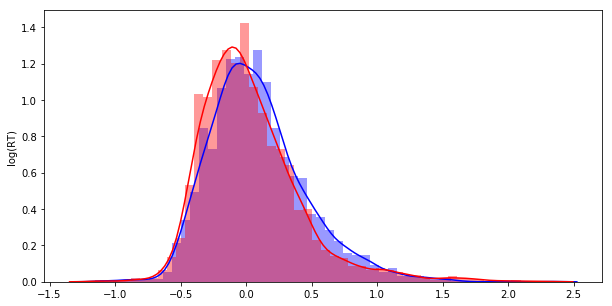

In [4]:
data_pre = allRaw.query('SESSION == 1')['logRT'].values
data_post = allRaw.query('SESSION == 2')['logRT'].values

fig, ax = plt.subplots(figsize=(10,5))

sns.distplot(data_pre, color = 'b')
_ = sns.distplot(data_post, color = 'r')
ax.set_ylabel('log(RT)')

Text(0,0.5,'log(RT)')

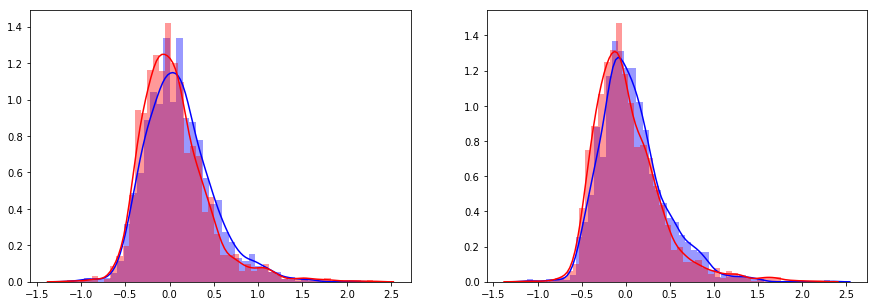

In [5]:
fig, ax = plt.subplots(figsize=(15,5))
ax1 = plt.subplot(121)
sns.distplot(allRaw.query('SESSION == 1 & HAND == 1')['logRT'].values, color='b')
_ = sns.distplot(allRaw.query('SESSION == 2 & HAND == 1')['logRT'].values, color='r')
ax.set_ylabel('log(RT)')

ax1 = plt.subplot(122)
sns.distplot(allRaw.query('SESSION == 1 & HAND == 2')['logRT'].values, color='b')
_ = sns.distplot(allRaw.query('SESSION == 2 & HAND == 2')['logRT'].values, color='r')
ax.set_ylabel('log(RT)')

### Filtered logRT distribution plots

Text(0,0.5,'log(RT)')

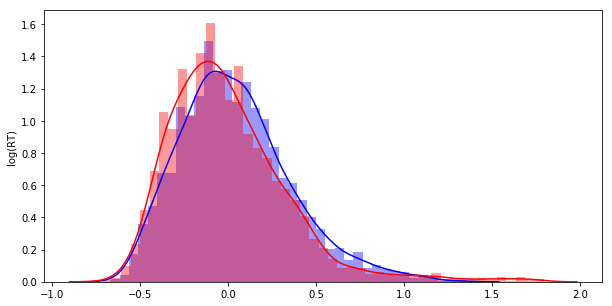

In [6]:
data_pre = allProcTot.query('SESSION == 1')['RT_LOG'].values
data_post = allProcTot.query('SESSION == 2')['RT_LOG'].values

fig, ax = plt.subplots(figsize=(10,5))

sns.distplot(data_pre, color = 'b')
_ = sns.distplot(data_post, color = 'r')
ax.set_ylabel('log(RT)')

Text(0,0.5,'log(RT)')

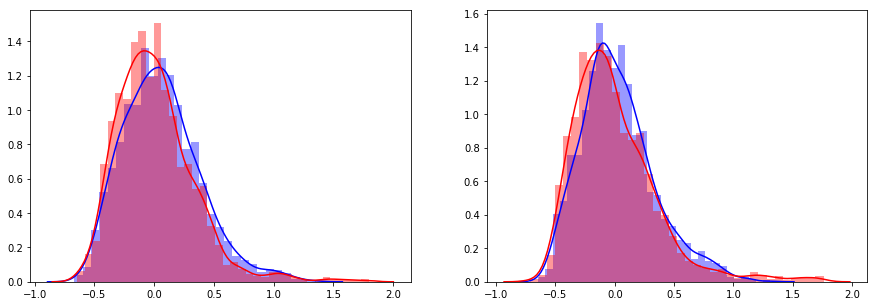

In [7]:
fig, ax = plt.subplots(figsize=(15,5))
ax1 = plt.subplot(121)
sns.distplot(allProcTot.query('SESSION == 1 & HAND == 1')['RT_LOG'].values, color='b')
_ = sns.distplot(allProcTot.query('SESSION == 2 & HAND == 1')['RT_LOG'].values, color='r')
ax.set_ylabel('log(RT)')

ax1 = plt.subplot(122)
sns.distplot(allProcTot.query('SESSION == 1 & HAND == 2')['RT_LOG'].values, color='b')
_ = sns.distplot(allProcTot.query('SESSION == 2 & HAND == 2')['RT_LOG'].values, color='r')
ax.set_ylabel('log(RT)')

### Mean scores per session

In [8]:
allMean.groupby('SESSION').mean()

,RT_LEFT,RT_RIGHT,ACC_LEFT,ACC_RIGHT,RT_TOTAL,ACC_TOTAL
SESSION,,,,,,
0.0,1.203168,1.236519,0.890600,0.905376,1.226206,0.897739
1.0,1.131173,1.093875,0.917532,0.916266,1.113726,0.916933
2.0,1.087039,1.081917,0.929415,0.936096,1.083233,0.932773


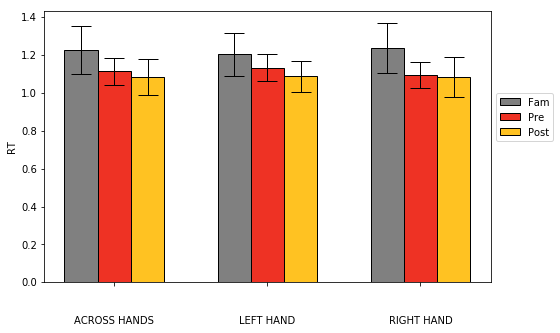

In [10]:
width = 0.25 
error_kw = {'capsize': 10, 'capthick': 1, 'ecolor': 'black','linewidth': 1}
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

plt.bar(0.55, allMean[allMean['SESSION']==0]['RT_TOTAL'].mean(), width, alpha=1, color='grey',edgecolor='k',linewidth=1, yerr=np.array([0, allMean[allMean['SESSION']==0]['RT_TOTAL'].std()/sqrt(len(subjects) - noFam)])[1], error_kw=error_kw) 
plt.bar(0.8, allMean[allMean['SESSION']==1]['RT_TOTAL'].mean(), width, alpha=1, color='#EE3224',edgecolor='k',linewidth=1, yerr=np.array([0, allMean[allMean['SESSION']==1]['RT_TOTAL'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(1.05, allMean[allMean['SESSION']==2]['RT_TOTAL'].mean(), width, alpha=1, color='#FFC222',edgecolor='k',linewidth=1, yerr=np.array([0, allMean[allMean['SESSION']==2]['RT_TOTAL'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

plt.bar(1.7, allMean[allMean['SESSION']==0]['RT_LEFT'].mean(), width, alpha=1, color='grey', edgecolor='k', linewidth=1, yerr=np.array([0,allMean[allMean['SESSION']==0]['RT_LEFT'].std()/sqrt(len(subjects) - noFam)])[1], error_kw=error_kw) 
plt.bar(1.95, allMean[allMean['SESSION']==1]['RT_LEFT'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0,allMean[allMean['SESSION']==1]['RT_LEFT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(2.2, allMean[allMean['SESSION']==2]['RT_LEFT'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0,allMean[allMean['SESSION']==2]['RT_LEFT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

plt.bar(2.85, allMean[allMean['SESSION']==0]['RT_RIGHT'].mean(), width, alpha=1, color='grey', edgecolor='k', linewidth=1, yerr=np.array([0,allMean[allMean['SESSION']==0]['RT_RIGHT'].std()/sqrt(len(subjects) - noFam)])[1], error_kw=error_kw) 
plt.bar(3.1, allMean[allMean['SESSION']==1]['RT_RIGHT'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0,allMean[allMean['SESSION']==1]['RT_RIGHT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(3.35, allMean[allMean['SESSION']==2]['RT_RIGHT'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0,allMean[allMean['SESSION']==2]['RT_RIGHT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

# Set the y axis label
ax.set_ylabel('RT')

# Set the position of the x ticks
ax.set_xticks([0.8,1.95,3.1])

# Set the labels for the x ticks
ax.set_xticklabels(["ACROSS HANDS", "LEFT HAND", "RIGHT HAND"])
ax.tick_params(axis='x', pad=30)

# Add gridline
#ax.grid(color='k', linestyle='--', linewidth=0.5, axis ='y', which="both")
ax.set_facecolor('xkcd:white')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(['Fam', 'Pre', 'Post'], loc='lower left', bbox_to_anchor=(1, 0.5))
    
plt.show()

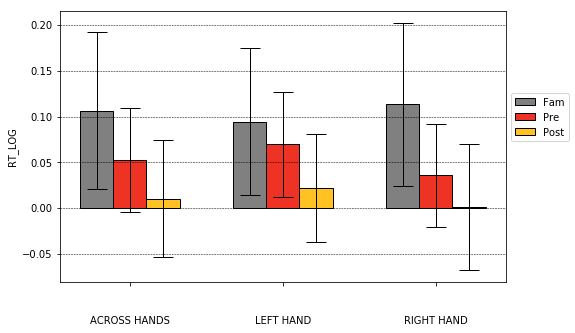

In [11]:
width = 0.25 
error_kw = {'capsize': 10, 'capthick': 1, 'ecolor': 'black','linewidth': 1}
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

plt.bar(0.55, allMeanLog[allMeanLog['SESSION']==0]['RT_TOTAL'].mean(), width, alpha=1, color='grey', edgecolor='k', linewidth=1, yerr=np.array([0, allMeanLog[allMeanLog['SESSION']==0]['RT_TOTAL'].std()/sqrt(len(subjects) - noFam)])[1], error_kw=error_kw) 
plt.bar(0.8, allMeanLog[allMeanLog['SESSION']==1]['RT_TOTAL'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0, allMeanLog[allMeanLog['SESSION']==1]['RT_TOTAL'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(1.05, allMeanLog[allMeanLog['SESSION']==2]['RT_TOTAL'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, allMeanLog[allMeanLog['SESSION']==2]['RT_TOTAL'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

plt.bar(1.7, allMeanLog[allMeanLog['SESSION']==0]['RT_LEFT'].mean(), width, alpha=1, color='grey', edgecolor='k', linewidth=1, yerr=np.array([0, allMeanLog[allMeanLog['SESSION']==0]['RT_LEFT'].std()/sqrt(len(subjects) - noFam)])[1], error_kw=error_kw) 
plt.bar(1.95, allMeanLog[allMeanLog['SESSION']==1]['RT_LEFT'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0, allMeanLog[allMeanLog['SESSION']==1]['RT_LEFT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(2.2, allMeanLog[allMeanLog['SESSION']==2]['RT_LEFT'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, allMeanLog[allMeanLog['SESSION']==2]['RT_LEFT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

plt.bar(2.85, allMeanLog[allMeanLog['SESSION']==0]['RT_RIGHT'].mean(), width, alpha=1, color='grey', edgecolor='k', linewidth=1, yerr=np.array([0, allMeanLog[allMeanLog['SESSION']==0]['RT_RIGHT'].std()/sqrt(len(subjects) - noFam)])[1], error_kw=error_kw) 
plt.bar(3.1, allMeanLog[allMeanLog['SESSION']==1]['RT_RIGHT'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0, allMeanLog[allMeanLog['SESSION']==1]['RT_RIGHT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(3.35, allMeanLog[allMeanLog['SESSION']==2]['RT_RIGHT'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, allMeanLog[allMeanLog['SESSION']==2]['RT_RIGHT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

# Set the y axis label
ax.set_ylabel('RT_LOG')

# Set the position of the x ticks
ax.set_xticks([0.8,1.95,3.1])

# Set the labels for the x ticks
ax.set_xticklabels(["ACROSS HANDS", "LEFT HAND", "RIGHT HAND"])
ax.tick_params(axis='x', pad=30)

# Add gridline
ax.grid(color='k', linestyle='--', linewidth=0.5, axis ='y', which="both")
ax.set_facecolor('xkcd:white')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(['Fam', 'Pre', 'Post'], loc='lower left', bbox_to_anchor=(1, 0.5))
    
plt.show()

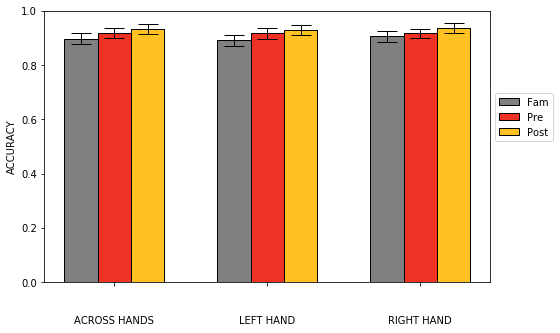

In [12]:
width = 0.25 
error_kw = {'capsize': 10, 'capthick': 1, 'ecolor': 'black','linewidth': 1}
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

plt.bar(0.55, allMeanLog[allMeanLog['SESSION']==0]['ACC_TOTAL'].mean(), width, alpha=1, color='grey', edgecolor='k', linewidth=1, yerr=np.array([0, allMeanLog[allMeanLog['SESSION']==0]['ACC_TOTAL'].std()/sqrt(len(subjects) - noFam)])[1], error_kw=error_kw) 
plt.bar(0.8, allMeanLog[allMeanLog['SESSION']==1]['ACC_TOTAL'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0, allMeanLog[allMeanLog['SESSION']==1]['ACC_TOTAL'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(1.05, allMeanLog[allMeanLog['SESSION']==2]['ACC_TOTAL'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, allMeanLog[allMeanLog['SESSION']==2]['ACC_TOTAL'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

plt.bar(1.7, allMeanLog[allMeanLog['SESSION']==0]['ACC_LEFT'].mean(), width, alpha=1, color='grey', edgecolor='k', linewidth=1, yerr=np.array([0, allMeanLog[allMeanLog['SESSION']==0]['ACC_LEFT'].std()/sqrt(len(subjects) - noFam)])[1], error_kw=error_kw) 
plt.bar(1.95, allMeanLog[allMeanLog['SESSION']==1]['ACC_LEFT'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0, allMeanLog[allMeanLog['SESSION']==1]['ACC_LEFT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(2.2, allMeanLog[allMeanLog['SESSION']==2]['ACC_LEFT'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, allMeanLog[allMeanLog['SESSION']==2]['ACC_LEFT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

plt.bar(2.85, allMeanLog[allMeanLog['SESSION']==0]['ACC_RIGHT'].mean(), width, alpha=1, color='grey', edgecolor='k', linewidth=1, yerr=np.array([0, allMeanLog[allMeanLog['SESSION']==0]['ACC_RIGHT'].std()/sqrt(len(subjects) - noFam)])[1], error_kw=error_kw) 
plt.bar(3.1, allMeanLog[allMeanLog['SESSION']==1]['ACC_RIGHT'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0, allMeanLog[allMeanLog['SESSION']==1]['ACC_RIGHT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(3.35, allMeanLog[allMeanLog['SESSION']==2]['ACC_RIGHT'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, allMeanLog[allMeanLog['SESSION']==2]['ACC_RIGHT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

# Set the y axis label
ax.set_ylabel('ACCURACY')

# Set the position of the x ticks
ax.set_xticks([0.8,1.95,3.1]) 

# Set the labels for the x ticks
ax.set_xticklabels(["ACROSS HANDS", "LEFT HAND", "RIGHT HAND"])
ax.tick_params(axis='x', pad=30)

# Add gridline
#ax.grid(color='k', linestyle='--', linewidth=0.5, axis ='y', which="both")
ax.set_facecolor('xkcd:white')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(['Fam', 'Pre', 'Post'], loc='lower left', bbox_to_anchor=(1, 0.5))

    
plt.show()

### Individual participants plots

#### Raw data

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


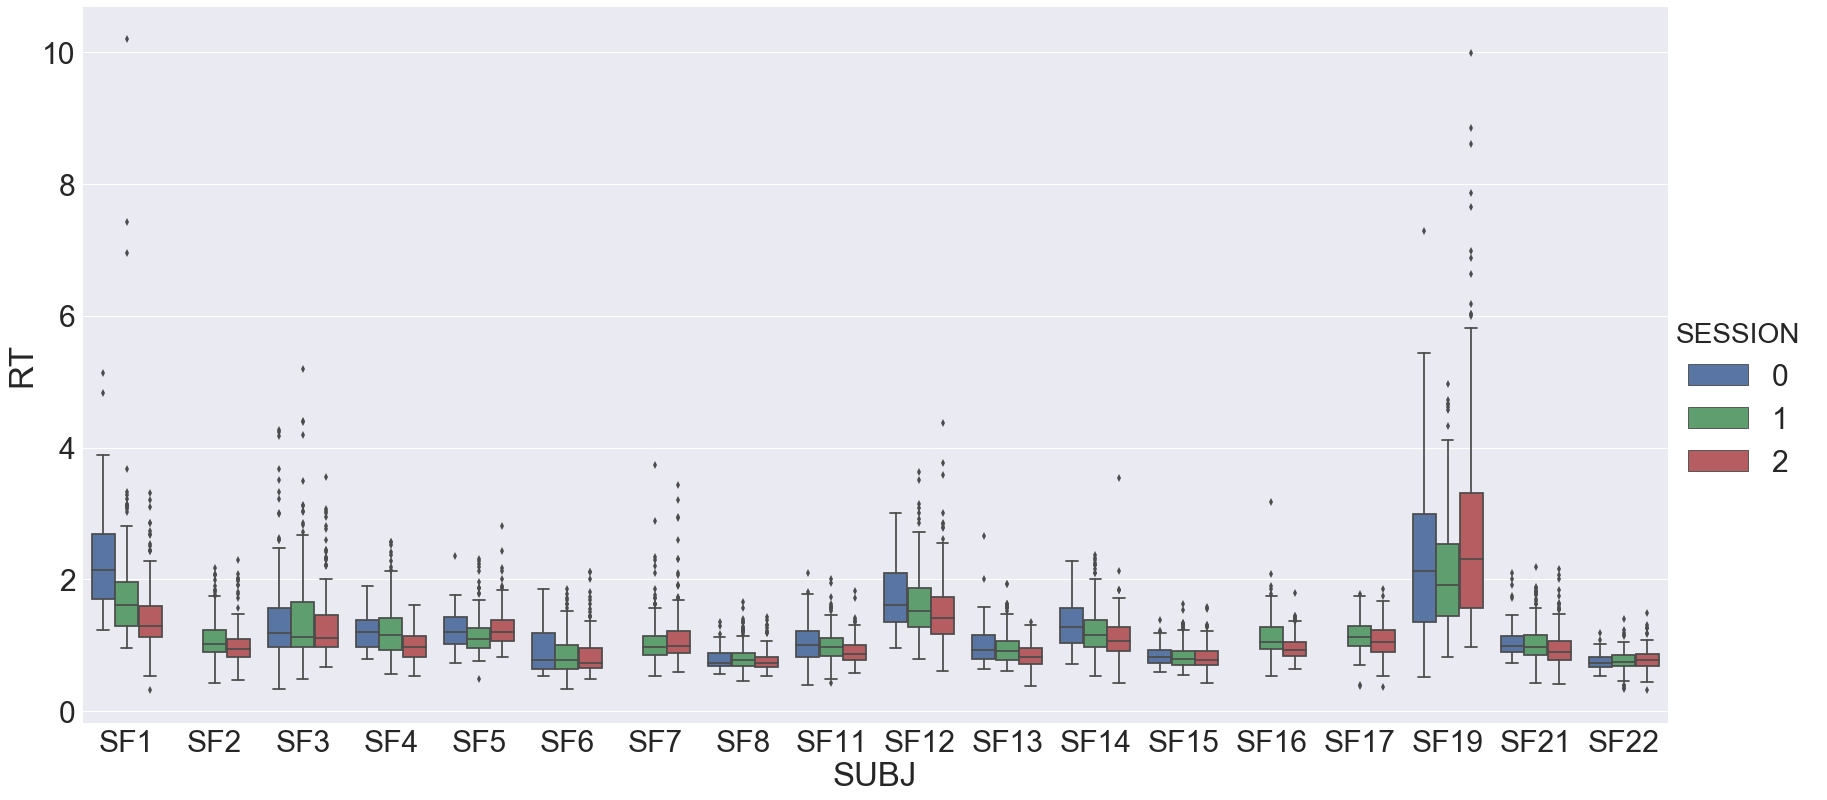

In [16]:
sns.set(font_scale = 3)
ax = sns.factorplot(x="SUBJ", y="RT", hue="SESSION", data=allRaw, kind="box",size=12, aspect=2);

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


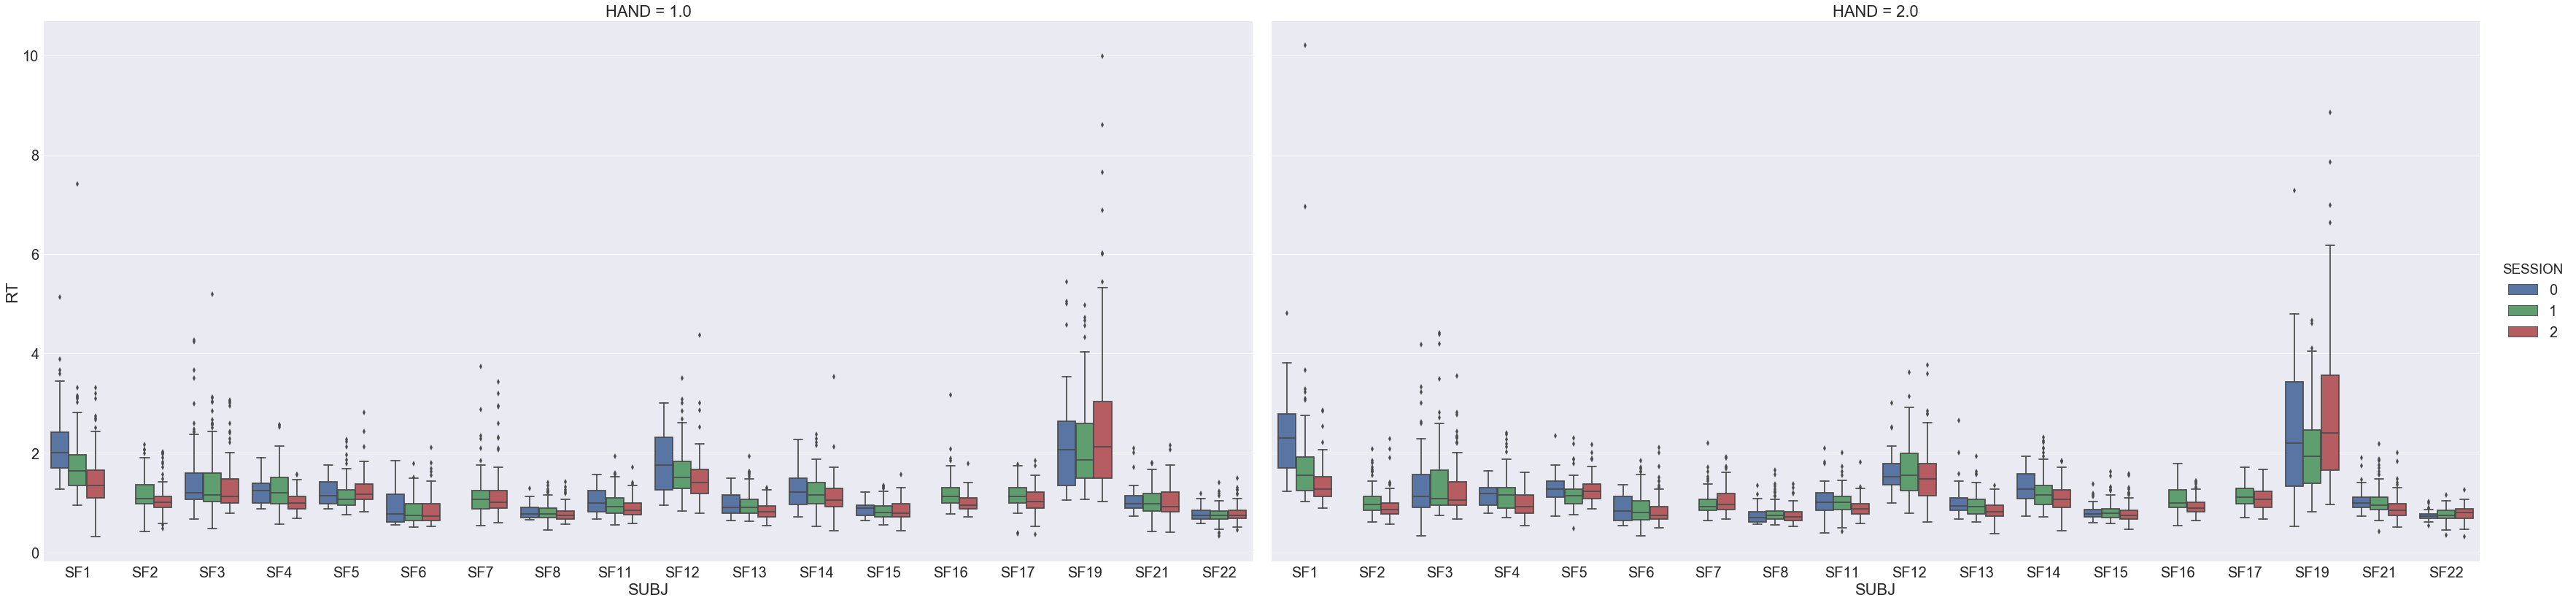

In [17]:
sns.set(font_scale = 2)
sns.factorplot(x="SUBJ", y="RT", hue="SESSION", col="HAND", data=allRaw, kind="box", size=12, aspect=2);

#### Log Transformed Data

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


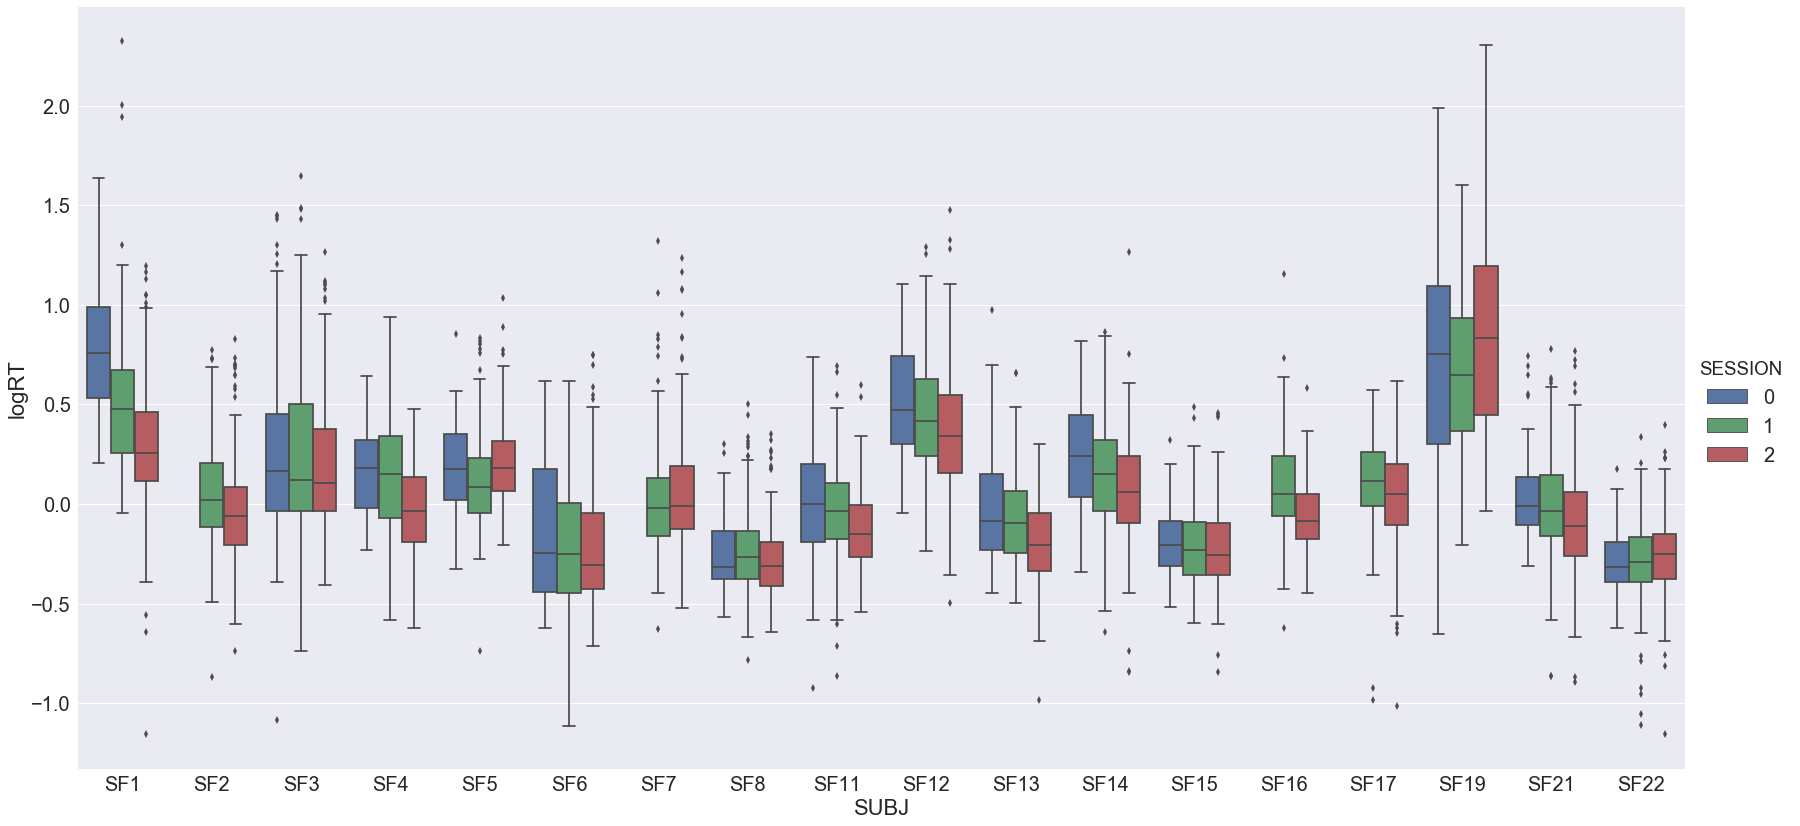

In [18]:
sns.set(font_scale = 2)
sns.factorplot(x="SUBJ", y="logRT", hue="SESSION", data=allRaw, kind="box", size=12, aspect=2);

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


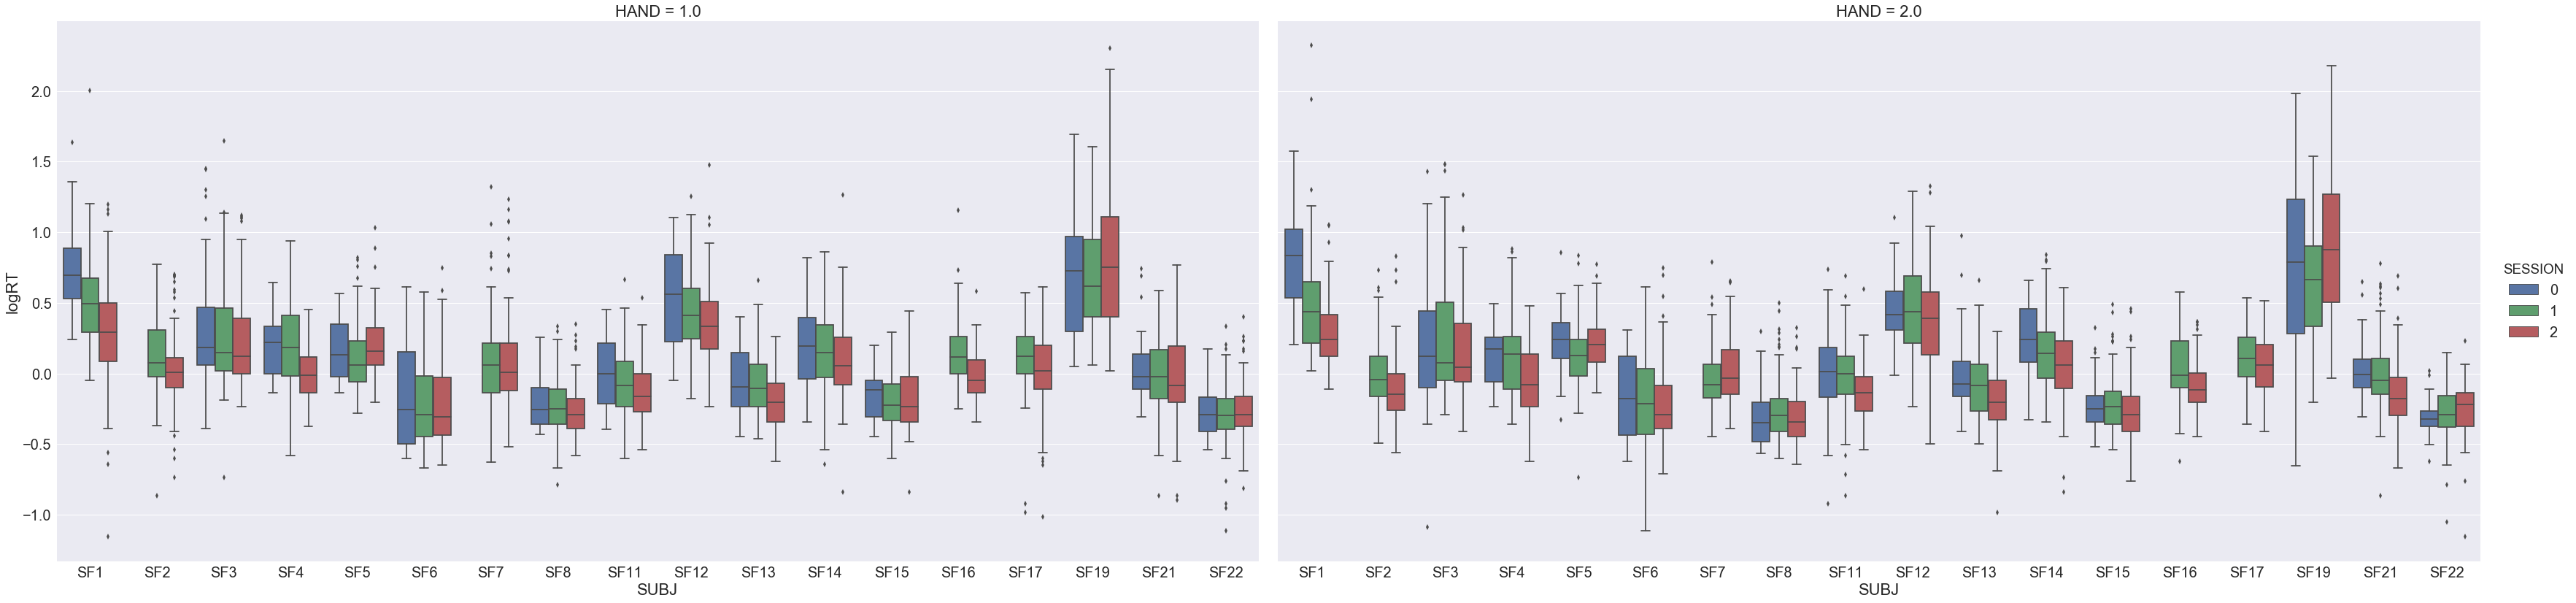

In [19]:
sns.set(font_scale = 2)
sns.factorplot(x="SUBJ", y="logRT", hue="SESSION", col="HAND", data=allRaw, kind="box", size=12, aspect=2);

#### STD Filtered Data

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


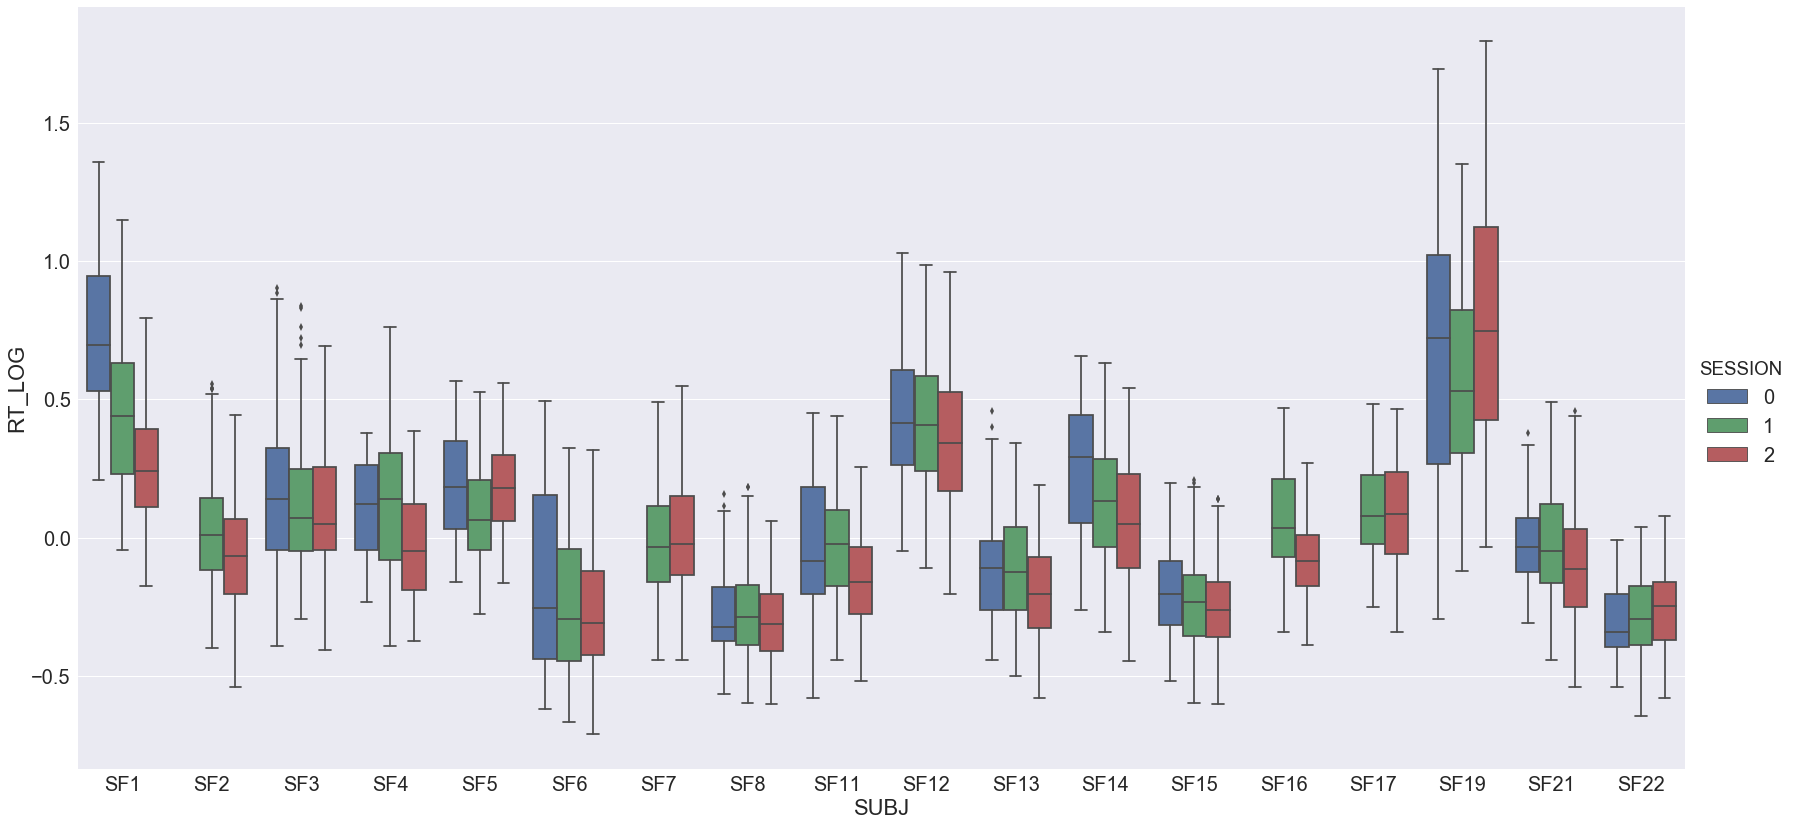

In [20]:
sns.set(font_scale = 2)
sns.factorplot(x="SUBJ", y="RT_LOG", hue="SESSION", data=allProcTot, kind="box", size=12, aspect=2);

/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:490: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


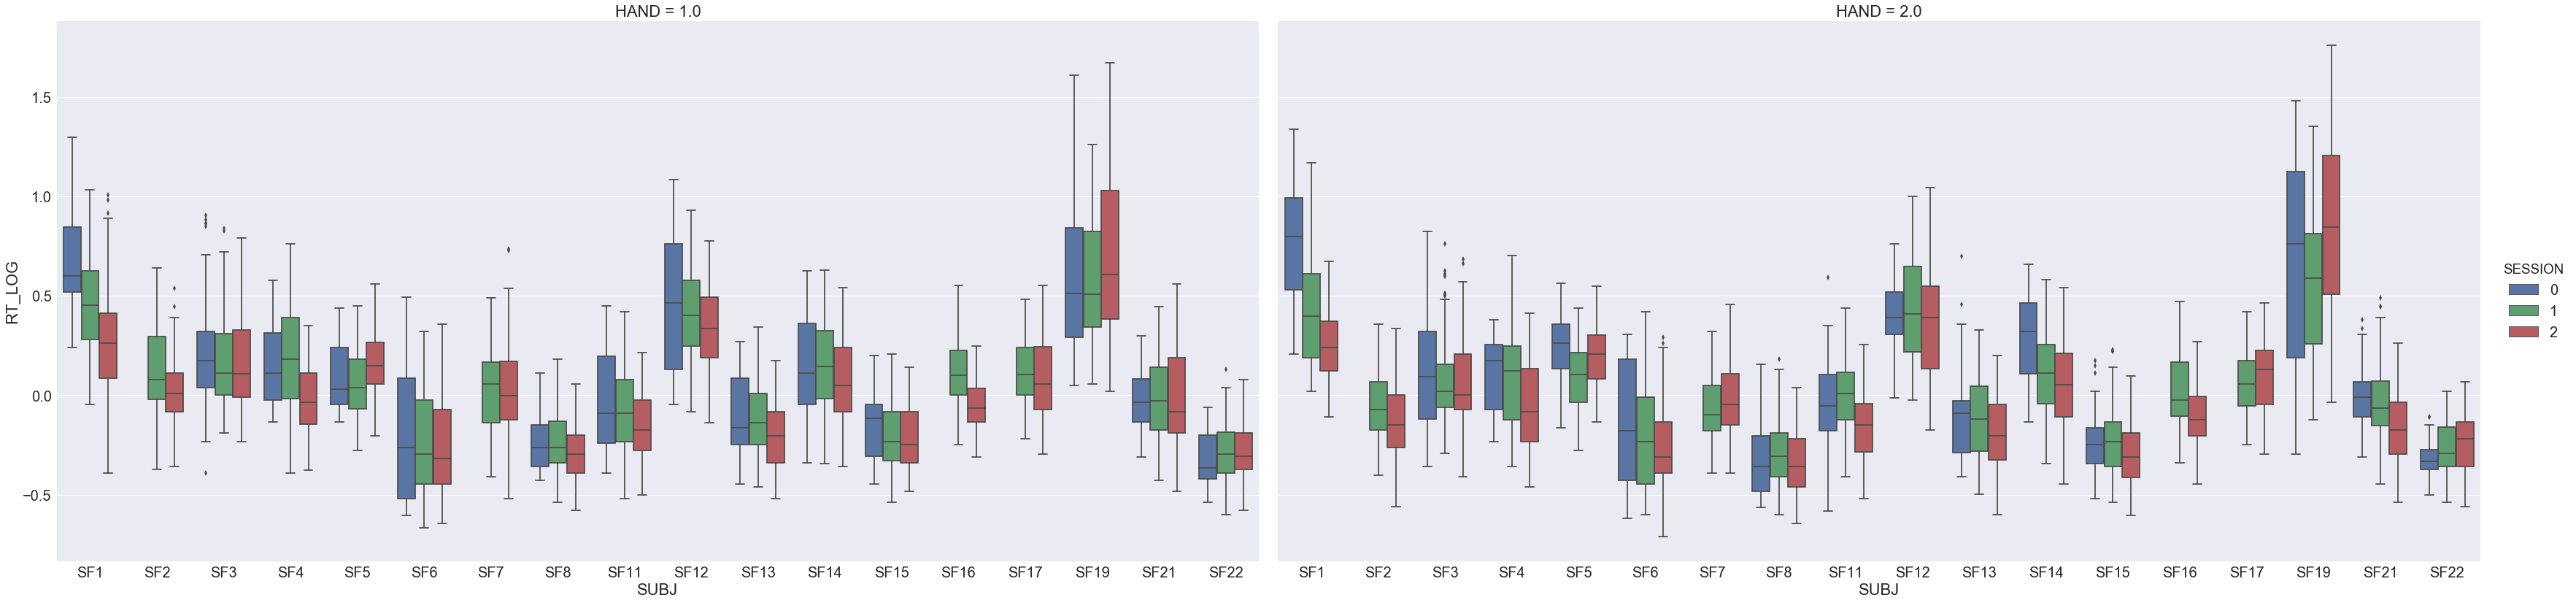

In [21]:
sns.set(font_scale = 2)
sns.factorplot(x="SUBJ", y="RT_LOG", hue="SESSION", col="HAND", data=allProc, kind="box", size=12, aspect=2);

In [13]:
pre = allMeanLog[allMeanLog['SESSION']==1]
pre = pre.dropna()

post = allMeanLog[allMeanLog['SESSION']==2]
post = post.dropna()

diff = post.subtract(pre)
diff = diff.iloc[:,0:6]
melted = pd.melt(diff.reset_index(), id_vars=["SUBJ"], var_name="Cat", value_name="Score")

In [15]:
melted_rt = melted.query('Cat in ["RT_LEFT","RT_RIGHT","RT_TOTAL"]')
melted_acc = melted.query('Cat in ["ACC_LEFT","ACC_RIGHT","ACC_TOTAL"]')

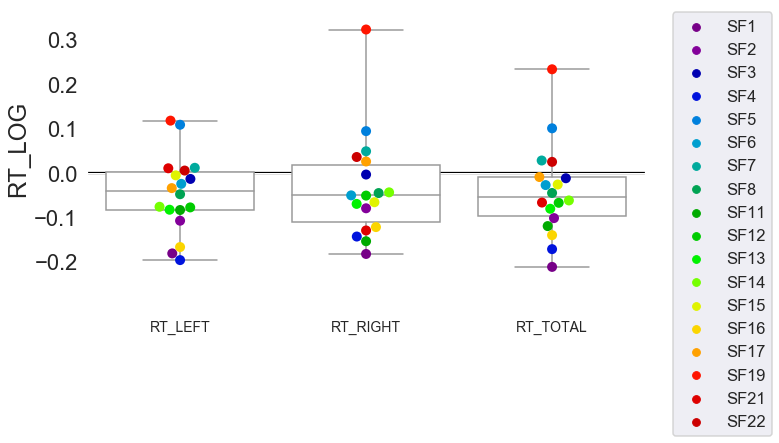

In [16]:
sns.set(font_scale = 2)
fig, ax = plt.subplots(figsize=(10,5))

ax = sns.boxplot(x="Cat", y="Score", data=melted_rt, whis=np.inf, color='white')
ax = sns.swarmplot(x="Cat", y="Score", hue="SUBJ", data=melted_rt, size=10, palette='nipy_spectral')
ax.set_xlabel('')
ax.set_ylabel('RT_LOG')
ax.tick_params(axis='x', pad=30, labelsize=14)
ax.set(facecolor='white')
sns.set_context("talk")
ax.axhline(0, xmin=0, color="black", zorder=0)
#ax.axvline(-0.5, color="black", zorder=0, linestyle='solid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

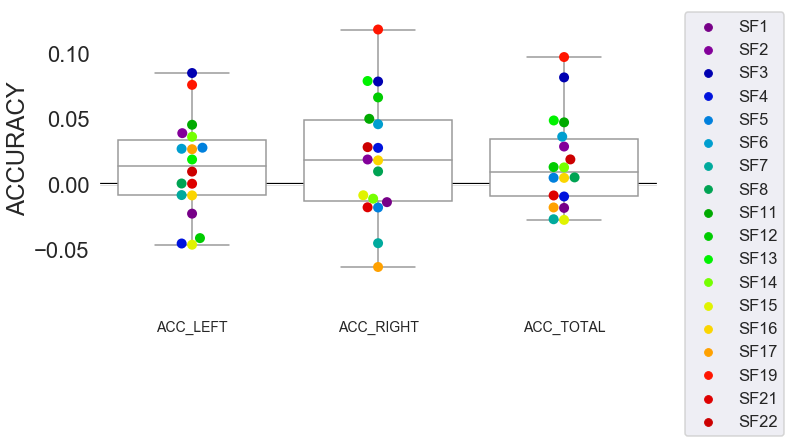

In [17]:
sns.set(font_scale = 2)
fig, ax = plt.subplots(figsize=(10,5))

ax = sns.boxplot(x="Cat", y="Score", data=melted_acc, whis=np.inf, color='white')
ax = sns.swarmplot(x="Cat", y="Score", hue="SUBJ", data=melted_acc, size=10, palette='nipy_spectral')
ax.set_xlabel('')
ax.set_ylabel('ACCURACY')
ax.tick_params(axis='x', pad=30, labelsize=14)
ax.set(facecolor='white')
sns.set_context("talk")
ax.axhline(0, xmin=0, color="black", zorder=0)
#ax.axvline(-0.5, color="black", zorder=0, linestyle='solid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

## Medial vs Lateral grouping (MOLA)

RT in hand laterality judgements have been previously suggested to be affected by the biomechanical constraints effect, a phenomenon in which RTs for hand pictures rotated laterally (fingers pointing away from the body) are larger than those rotated medially. Here, we check explore the effect of the Third Thumb training on hand laterality judgement, while separating the stimuli into medial and lateral hand orientation.

In [20]:
allProc['MOLA'] = np.where(((allProc['HAND']==1) & (allProc['ORIENTATION'] < 180) & (allProc['ORIENTATION'] > 0)) |
                  ((allProc['HAND']==2) & (allProc['ORIENTATION'] > 180)), 'Medial', 'Lateral')
allProc.loc[allProc['ORIENTATION'] == 0, 'MOLA'] = ''
allProc

,HAND,POSE,ORIENTATION,ANSWER,RT,ACC,SUBJ,SESSION,RT_LOG,mean,std,MOLA
1,1.0,1.0,30.0,1.0,2.420,True,SF1,0,0.883768,0.715629,0.320161,Medial
3,2.0,2.0,30.0,2.0,2.300,True,SF1,0,0.832909,0.795625,0.339378,Lateral
4,1.0,3.0,270.0,1.0,2.010,True,SF1,0,0.698135,0.715629,0.320161,Lateral
5,1.0,4.0,30.0,1.0,3.450,True,SF1,0,1.238374,0.715629,0.320161,Medial
6,2.0,3.0,150.0,2.0,3.160,True,SF1,0,1.150572,0.795625,0.339378,Lateral
7,1.0,4.0,150.0,1.0,1.720,True,SF1,0,0.542324,0.715629,0.320161,Medial
8,2.0,4.0,210.0,2.0,1.790,True,SF1,0,0.582216,0.795625,0.339378,Medial
9,1.0,1.0,330.0,1.0,1.580,True,SF1,0,0.457425,0.715629,0.320161,Lateral
10,2.0,4.0,90.0,2.0,1.660,True,SF1,0,0.506818,0.795625,0.339378,Lateral
11,1.0,3.0,330.0,1.0,2.650,True,SF1,0,0.974560,0.715629,0.320161,Lateral


In [21]:
Mola = allProc.groupby(['SUBJ', 'SESSION', 'HAND', 'MOLA', 'ORIENTATION', 'POSE'])['RT_LOG'].mean().reset_index()
allMola = Mola[Mola['SESSION'] != 0]
allMola = allMola[allMola['SUBJ'] != "SF19"]
allMola.groupby('MOLA')['RT_LOG'].std()

MOLA
           0.235538
Lateral    0.254408
Medial     0.252585
Name: RT_LOG, dtype: float64

<function matplotlib.pyplot.show>

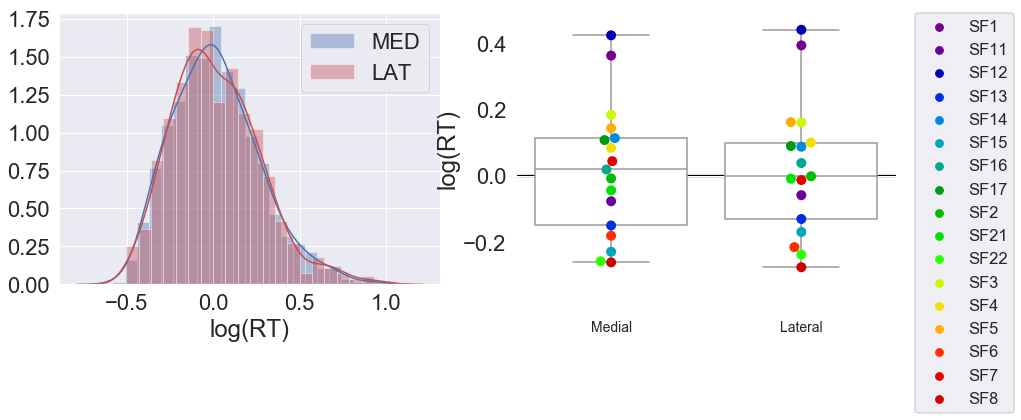

In [22]:
data_med = allMola.query('MOLA == "Medial"')['RT_LOG'].values
data_lat = allMola.query('MOLA == "Lateral"')['RT_LOG'].values
sns.set(font_scale = 2)

fig, ax = plt.subplots(figsize=(15,5))

ax1 = plt.subplot(121)
sns.distplot(data_med, color='b')
_ = sns.distplot(data_lat, color='r')
ax1.set_xlabel('log(RT)')
ax1.legend(['MED','LAT'])

ax2 = plt.subplot(122)
ax2 = sns.boxplot(x="MOLA", y="RT_LOG", data=allMola.groupby(['SUBJ', 'MOLA'])['RT_LOG'].mean().reset_index(), whis=np.inf, color='white', order=['Medial', 'Lateral'])
ax2 = sns.swarmplot(x="MOLA", y="RT_LOG", hue="SUBJ", data=allMola.groupby(['SUBJ', 'MOLA'])['RT_LOG'].mean().reset_index(), size=10, palette='nipy_spectral', order=['Medial', 'Lateral'])
ax2.set_xlabel('')
ax2.set_ylabel('log(RT)')
ax2.tick_params(axis='x',pad=30, labelsize=14)
ax2.set(facecolor='white')
sns.set_context("talk")
ax2.axhline(0, xmin=0, color="black", zorder=0)
#ax.axvline(-0.5, color="black", zorder=0, linestyle='solid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show

In [23]:
stats.ttest_rel(allMola[allMola['MOLA']=="Medial"].groupby(['SUBJ'])['RT_LOG'].mean(), allMola[allMola['MOLA']=="Lateral"].groupby(['SUBJ'])['RT_LOG'].mean())
stats.wilcoxon(allMola[allMola['MOLA']=="Medial"].groupby(['SUBJ'])['RT_LOG'].mean(), allMola[allMola['MOLA']=="Lateral"].groupby(['SUBJ'])['RT_LOG'].mean())

WilcoxonResult(statistic=60.0, pvalue=0.43475617175843206)

#### PRE MOLA

In [24]:
allMolaPre = allMola[allMola['SESSION']==1]
allMolaPre = allMolaPre[allMolaPre['SUBJ']!="SF19"]
allMolaPre.groupby('MOLA')['RT_LOG'].mean()

MOLA
          -0.022862
Lateral    0.051972
Medial     0.043542
Name: RT_LOG, dtype: float64

<function matplotlib.pyplot.show>

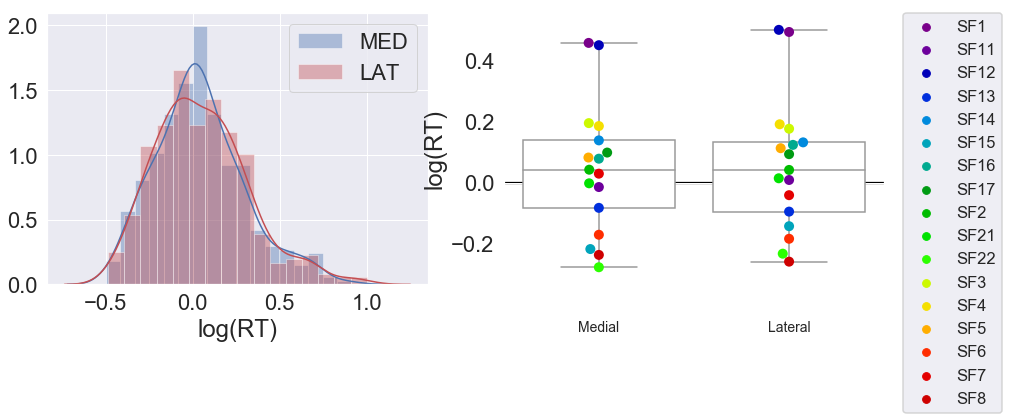

In [25]:
data_med = allMolaPre.query('MOLA == "Medial"')['RT_LOG'].values
data_lat = allMolaPre.query('MOLA == "Lateral"')['RT_LOG'].values
sns.set(font_scale = 2)

fig, ax = plt.subplots(figsize=(15,5))

ax1 = plt.subplot(121)
sns.distplot(data_med, color='b')
_ = sns.distplot(data_lat, color='r')
ax1.set_xlabel('log(RT)')
ax1.legend(['MED','LAT'])

ax2 = plt.subplot(122)
ax2 = sns.boxplot(x="MOLA", y="RT_LOG", data=allMolaPre.groupby(['SUBJ','MOLA'])['RT_LOG'].mean().reset_index(), whis=np.inf, color='white', order=['Medial', 'Lateral'])
ax2 = sns.swarmplot(x="MOLA", y="RT_LOG", hue="SUBJ", data=allMolaPre.groupby(['SUBJ','MOLA'])['RT_LOG'].mean().reset_index(), size=10, palette='nipy_spectral', order=['Medial', 'Lateral'])
ax2.set_xlabel('')
ax2.set_ylabel('log(RT)')
ax2.tick_params(axis='x', pad=30, labelsize=14)
ax2.set(facecolor='white')
sns.set_context("talk")
ax2.axhline(0, xmin=0, color="black", zorder=0)
#ax.axvline(-0.5, color="black", zorder=0, linestyle='solid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.show

In [26]:
stats.ttest_rel(allMolaPre[allMolaPre['MOLA']=="Medial"].groupby(['SUBJ'])['RT_LOG'].mean(), allMolaPre[allMolaPre['MOLA']=="Lateral"].groupby(['SUBJ'])['RT_LOG'].mean())
stats.wilcoxon(allMolaPre[allMolaPre['MOLA']=="Medial"].groupby(['SUBJ'])['RT_LOG'].mean(), allMolaPre[allMolaPre['MOLA']=="Lateral"].groupby(['SUBJ'])['RT_LOG'].mean())

WilcoxonResult(statistic=51.0, pvalue=0.22738526970373263)

#### POST MOLA

In [27]:
allMolaPost = allMola[allMola['SESSION']==2]
allMolaPost = allMolaPost[allMolaPost['SUBJ']!="SF19"]
allMolaPost.groupby('MOLA')['RT_LOG'].mean()

MOLA
          -0.088316
Lateral   -0.017103
Medial    -0.011658
Name: RT_LOG, dtype: float64

<function matplotlib.pyplot.show>

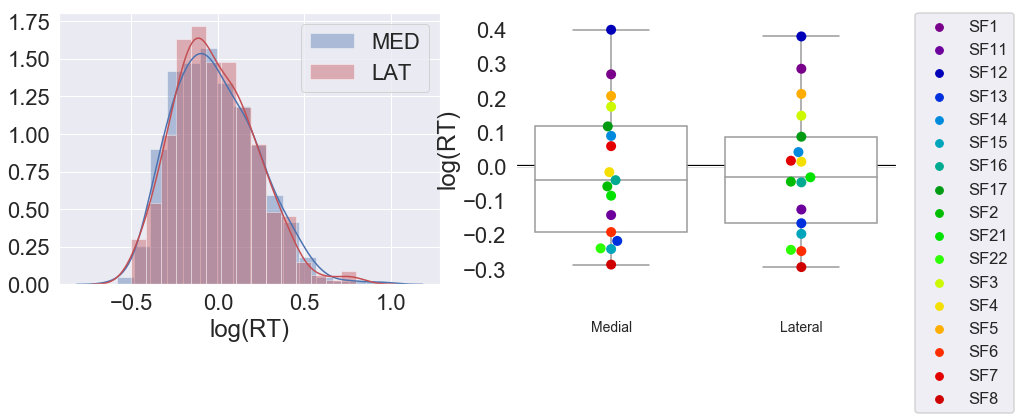

In [28]:
data_med = allMolaPost.query('MOLA == "Medial"')['RT_LOG'].values
data_lat = allMolaPost.query('MOLA == "Lateral"')['RT_LOG'].values
sns.set(font_scale = 2)

fig, ax = plt.subplots(figsize=(15,5))

ax1 = plt.subplot(121)
sns.distplot(data_med, color='b')
_ = sns.distplot(data_lat, color='r')
ax1.set_xlabel('log(RT)')
ax1.legend(['MED', 'LAT'])

ax2=plt.subplot(122)
ax2 = sns.boxplot(x="MOLA", y="RT_LOG", data=allMolaPost.groupby(['SUBJ', 'MOLA'])['RT_LOG'].mean().reset_index(), whis=np.inf, color='white', order=['Medial','Lateral'])
ax2 = sns.swarmplot(x="MOLA", y="RT_LOG", hue="SUBJ", data=allMolaPost.groupby(['SUBJ', 'MOLA'])['RT_LOG'].mean().reset_index(), size=10, palette='nipy_spectral', order=['Medial','Lateral'])
ax2.set_xlabel('')
ax2.set_ylabel('log(RT)')
ax2.tick_params(axis='x', pad=30, labelsize=14)
ax2.set(facecolor='white')
sns.set_context("talk")
ax2.axhline(0, xmin=0, color="black", zorder=0)
#ax.axvline(-0.5, color="black", zorder=0, linestyle='solid')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.show

In [29]:
stats.ttest_rel(allMolaPost[allMolaPost['MOLA']=="Medial"].groupby(['SUBJ'])['RT_LOG'].mean(), allMolaPost[allMolaPost['MOLA']=="Lateral"].groupby(['SUBJ'])['RT_LOG'].mean())
stats.wilcoxon(allMolaPost[allMolaPost['MOLA']=="Medial"].groupby(['SUBJ'])['RT_LOG'].mean(), allMolaPost[allMolaPost['MOLA']=="Lateral"].groupby(['SUBJ'])['RT_LOG'].mean())

WilcoxonResult(statistic=75.0, pvalue=0.9433920568226559)

#### Split the data into Medial & Lateral poses

In [ ]:
MolaSplit = allProc.groupby(['SUBJ', 'SESSION', 'HAND', 'MOLA'])['RT_LOG', 'RT'].mean().reset_index()
MolaSplit = MolaSplit[MolaSplit['SESSION'] != 0]
MolaSplit = MolaSplit[MolaSplit['MOLA'] != ""]

In [31]:
MolaSplit.groupby(['MOLA','HAND','SESSION']).mean()

RT_LOG        RT
MOLA    HAND SESSION                    
Lateral 1.0  1        0.082221  1.144681
             2        0.029871  1.096214
        2.0  1        0.045258  1.104858
             2        0.010715  1.097188
Medial  1.0  1        0.075309  1.137850
             2        0.034180  1.105882
        2.0  1        0.049881  1.108544
             2        0.013769  1.094370

### Medial

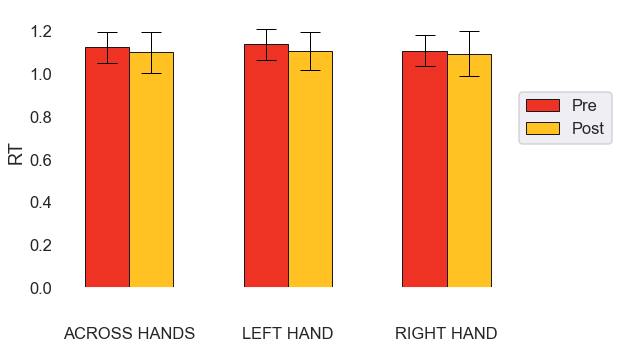

In [32]:
width = 0.25 
error_kw = {'capsize': 10, 'capthick': 1, 'ecolor': 'black','linewidth': 1}
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

plt.bar(0.55, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Medial")]['RT'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Medial")]['RT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(0.8, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Medial")]['RT'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Medial")]['RT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

plt.bar(1.45, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Medial") & (MolaSplit['HAND']==1)]['RT'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Medial") & (MolaSplit['HAND']==1)]['RT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(1.7, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Medial") & (MolaSplit['HAND']==1)]['RT'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Medial") & (MolaSplit['HAND']==1)]['RT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

plt.bar(2.35, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Medial") & (MolaSplit['HAND']==2)]['RT'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Medial") & (MolaSplit['HAND']==2)]['RT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(2.6, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Medial") & (MolaSplit['HAND']==2)]['RT'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Medial") & (MolaSplit['HAND']==2)]['RT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

# Set the y axis label
ax.set_ylabel('RT')

# Set the position of the x ticks
ax.set_xticks([0.675,1.575,2.475])

# Set the labels for the x ticks
ax.set_xticklabels(["ACROSS HANDS", "LEFT HAND", "RIGHT HAND"])
ax.tick_params(axis='x', pad=30)
# Add gridline
#ax.grid(color='k', linestyle='--', linewidth=0.5, axis ='y', which="both")
ax.set_facecolor('xkcd:white')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(['Pre', 'Post'],loc='lower left', bbox_to_anchor=(1, 0.5))
    
plt.show()

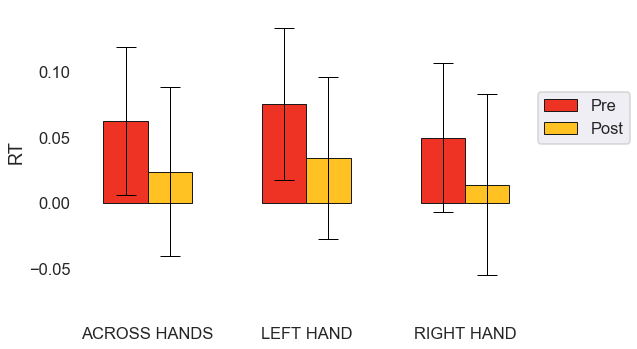

In [33]:
width = 0.25 
error_kw = {'capsize': 10, 'capthick': 1, 'ecolor': 'black','linewidth': 1}
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

plt.bar(0.55, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Medial")]['RT_LOG'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0,MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Medial")]['RT_LOG'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(0.8, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Medial")]['RT_LOG'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0,MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Medial")]['RT_LOG'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

plt.bar(1.45, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Medial") & (MolaSplit['HAND']==1)]['RT_LOG'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Medial") & (MolaSplit['HAND']==1)]['RT_LOG'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(1.7, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Medial") & (MolaSplit['HAND']==1)]['RT_LOG'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Medial") & (MolaSplit['HAND']==1)]['RT_LOG'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

plt.bar(2.35, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Medial") & (MolaSplit['HAND']==2)]['RT_LOG'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Medial") & (MolaSplit['HAND']==2)]['RT_LOG'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(2.6, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Medial") & (MolaSplit['HAND']==2)]['RT_LOG'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Medial") & (MolaSplit['HAND']==2)]['RT_LOG'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

# Set the y axis label
ax.set_ylabel('RT')

# Set the position of the x ticks
ax.set_xticks([0.675,1.575,2.475])

# Set the labels for the x ticks
ax.set_xticklabels(["ACROSS HANDS", "LEFT HAND", "RIGHT HAND"])
ax.tick_params(axis='x',pad=30)
# Add gridline
#ax.grid(color='k', linestyle='--', linewidth=0.5, axis ='y', which="both")
ax.set_facecolor('xkcd:white')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(['Pre', 'Post'],loc='lower left', bbox_to_anchor=(1, 0.5))
    
plt.show()

### Lateral

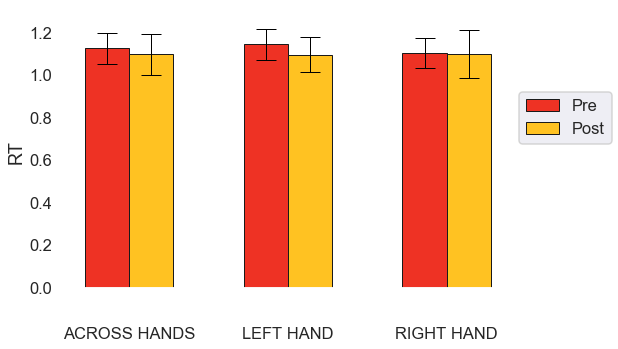

In [34]:
width = 0.25 
error_kw = {'capsize': 10, 'capthick': 1, 'ecolor': 'black','linewidth': 1}
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

plt.bar(0.55, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Lateral")]['RT'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Lateral")]['RT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(0.8, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Lateral")]['RT'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Lateral")]['RT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

plt.bar(1.45, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Lateral") & (MolaSplit['HAND']==1)]['RT'].mean(), width, alpha=1, color='#EE3224' ,edgecolor='k', linewidth=1, yerr=np.array([0, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Lateral") & (MolaSplit['HAND']==1)]['RT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(1.7, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Lateral") & (MolaSplit['HAND']==1)]['RT'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Lateral") & (MolaSplit['HAND']==1)]['RT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

plt.bar(2.35, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Lateral") & (MolaSplit['HAND']==2)]['RT'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Lateral") & (MolaSplit['HAND']==2)]['RT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(2.6, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Lateral") & (MolaSplit['HAND']==2)]['RT'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Lateral") & (MolaSplit['HAND']==2)]['RT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

# Set the y axis label
ax.set_ylabel('RT')

# Set the position of the x ticks
ax.set_xticks([0.675,1.575,2.475])

# Set the labels for the x ticks
ax.set_xticklabels(["ACROSS HANDS", "LEFT HAND", "RIGHT HAND"])
ax.tick_params(axis='x', pad=30)
# Add gridline
#ax.grid(color='k', linestyle='--', linewidth=0.5, axis ='y', which="both")
ax.set_facecolor('xkcd:white')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(['Pre', 'Post'],loc='lower left', bbox_to_anchor=(1, 0.5))
    
plt.show()

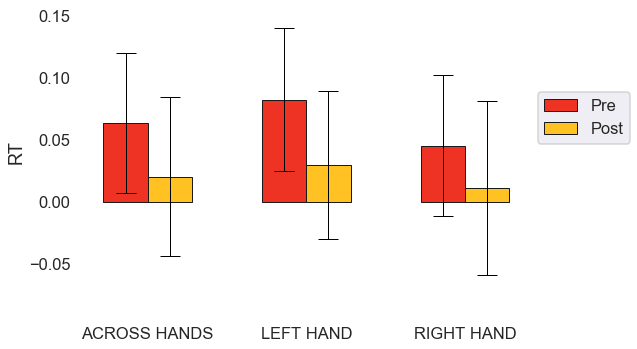

In [35]:
width = 0.25 
error_kw = {'capsize': 10, 'capthick': 1, 'ecolor': 'black','linewidth': 1}
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

plt.bar(0.55, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Lateral")]['RT_LOG'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Lateral")]['RT_LOG'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(0.8, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Lateral")]['RT_LOG'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Lateral")]['RT_LOG'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

plt.bar(1.45, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Lateral") & (MolaSplit['HAND']==1)]['RT_LOG'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Lateral") & (MolaSplit['HAND']==1)]['RT_LOG'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(1.7, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Lateral") & (MolaSplit['HAND']==1)]['RT_LOG'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Lateral") & (MolaSplit['HAND']==1)]['RT_LOG'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

plt.bar(2.35, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Lateral") & (MolaSplit['HAND']==2)]['RT_LOG'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0, MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Lateral") & (MolaSplit['HAND']==2)]['RT_LOG'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(2.6, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Lateral") & (MolaSplit['HAND']==2)]['RT_LOG'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Lateral") & (MolaSplit['HAND']==2)]['RT_LOG'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

# Set the y axis label
ax.set_ylabel('RT')

# Set the position of the x ticks
ax.set_xticks([0.675,1.575,2.475])

# Set the labels for the x ticks
ax.set_xticklabels(["ACROSS HANDS", "LEFT HAND", "RIGHT HAND"])
ax.tick_params(axis='x', pad=30)
# Add gridline
#ax.grid(color='k', linestyle='--', linewidth=0.5, axis ='y', which="both")
ax.set_facecolor('xkcd:white')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(['Pre', 'Post'],loc='lower left', bbox_to_anchor=(1, 0.5))
    
plt.show()

In [38]:
stats.ttest_rel(MolaSplit[(MolaSplit['SESSION']==1) & (MolaSplit['MOLA']=="Medial") & (MolaSplit['HAND']==2)]['RT_LOG'],
         MolaSplit[(MolaSplit['SESSION']==2) & (MolaSplit['MOLA']=="Medial") & (MolaSplit['HAND']==2)]['RT_LOG'])

Ttest_relResult(statistic=1.379609776964151, pvalue=0.18558495792734672)

## Awkwardness Ratings

Some of the hand orientations included in the stimuli are more awkward to imagine than others. Previous studies suggest this may affect the recorded RTs, such that more awkward orientations would be associated with larger RTs. Here, we explore whether the potential effect of Third Thumb training on hand laterality judgements could be specific to less/more awkward poses.

In [39]:
awkwardRate = pd.read_csv('akwardHLJ.csv')
allProcAw = pd.merge(allProc, awkwardRate, on=['HAND', 'POSE', 'ORIENTATION'])

In [41]:
Awkward = allProcAw.groupby(['SUBJ', 'SESSION', 'HAND', 'AWKWARD', 'ORIENTATION', 'POSE'])['RT_LOG'].mean().reset_index()
allAw = Awkward[Awkward['SESSION'] != 0]
allAw = allAw[allAw['SUBJ'] != "SF19"]
allAw.groupby('AWKWARD')['RT_LOG'].std()

AWKWARD
1.286    0.231740
1.357    0.218623
1.429    0.223850
1.571    0.265171
1.714    0.205317
1.786    0.265741
1.857    0.227177
1.929    0.222665
2.000    0.248960
2.071    0.251425
2.143    0.261086
2.240    0.265311
2.643    0.261161
2.857    0.258121
3.000    0.243279
3.429    0.229623
3.500    0.269928
3.714    0.203258
3.857    0.290025
Name: RT_LOG, dtype: float64

<function matplotlib.pyplot.show>

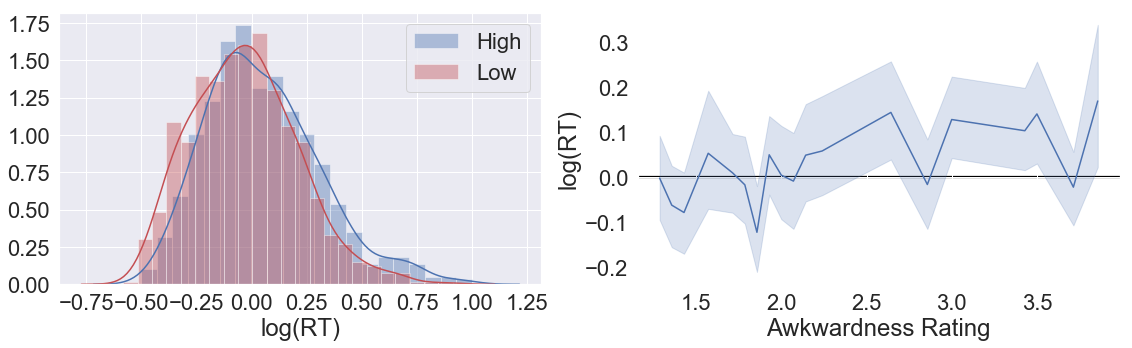

In [52]:
high_aw = allAw.query('AWKWARD > 1.929')['RT_LOG'].values
low_aw = allAw.query('AWKWARD <= 1.929')['RT_LOG'].values
sns.set(font_scale = 2)

fig, ax = plt.subplots(figsize=(19,5))

ax1 = plt.subplot(121)
sns.distplot(high_aw, color='b')
_ = sns.distplot(low_aw, color='r')
ax1.set_xlabel('log(RT)')
ax1.legend(['High','Low'])

ax2 = plt.subplot(122)
ax2 = sns.lineplot(x="AWKWARD", y="RT_LOG", data=allAw.groupby(['SUBJ', 'AWKWARD'])['RT_LOG'].mean().reset_index())
ax2.set_xlabel('Awkwardness Rating')
ax2.set_ylabel('log(RT)')
#ax2.tick_params(axis='x', pad=30, labelsize=14)
ax2.set(facecolor='white')
sns.set_context("talk")
ax2.axhline(0, xmin=0,color="black",zorder=0)
#ax.axvline(-0.5, color="black", zorder=0, linestyle='solid')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show

In [ ]:
allProcAw['AW_GROUP'] = np.where(allProcAw['AWKWARD'] > 3, 'High', 'Low')
AwSplit = allProcAw.groupby(['SUBJ', 'SESSION', 'HAND', 'AW_GROUP'])['RT_LOG', 'RT'].mean().reset_index()
AwSplit = AwSplit[AwSplit['SESSION'] != 0]

In [109]:
AwSplit.groupby(['AW_GROUP', 'HAND', 'SESSION']).mean()

RT_LOG        RT
AW_GROUP HAND SESSION                    
High     1.0  1        0.140138  1.214756
              2        0.106364  1.177772
         2.0  1        0.117927  1.186359
              2        0.084316  1.180799
Low      1.0  1        0.058744  1.118937
              2        0.009430  1.073824
         2.0  1        0.024674  1.081864
              2       -0.010220  1.068994

#### High awkwardness

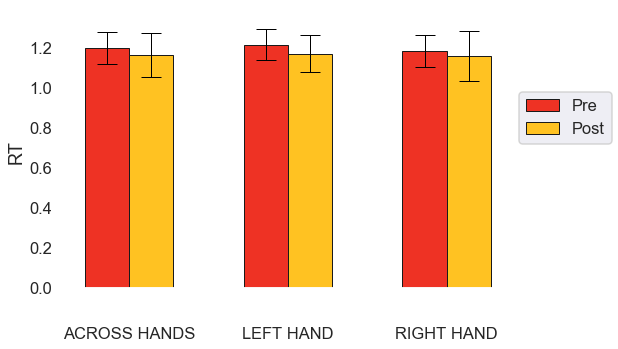

In [105]:
width = 0.25 
error_kw = {'capsize': 10, 'capthick': 1, 'ecolor': 'black','linewidth': 1}
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

plt.bar(0.55, AwSplit[(AwSplit['SESSION']==1) & (AwSplit['AW_GROUP']=="High")]['RT'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0, AwSplit[(AwSplit['SESSION']==1) & (AwSplit['AW_GROUP']=="High")]['RT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(0.8, AwSplit[(AwSplit['SESSION']==2) & (AwSplit['AW_GROUP']=="High")]['RT'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, AwSplit[(AwSplit['SESSION']==2) & (AwSplit['AW_GROUP']=="High")]['RT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

plt.bar(1.45, AwSplit[(AwSplit['SESSION']==1) & (AwSplit['AW_GROUP']=="High") & (AwSplit['HAND']==1)]['RT'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0, AwSplit[(AwSplit['SESSION']==1) & (AwSplit['AW_GROUP']=="High") & (AwSplit['HAND']==1)]['RT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(1.7, AwSplit[(AwSplit['SESSION']==2) & (AwSplit['AW_GROUP']=="High") & (AwSplit['HAND']==1)]['RT'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, AwSplit[(AwSplit['SESSION']==2) & (AwSplit['AW_GROUP']=="High") & (AwSplit['HAND']==1)]['RT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

plt.bar(2.35, AwSplit[(AwSplit['SESSION']==1) & (AwSplit['AW_GROUP']=="High") & (AwSplit['HAND']==2)]['RT'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0, AwSplit[(AwSplit['SESSION']==1) & (AwSplit['AW_GROUP']=="High") & (AwSplit['HAND']==2)]['RT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(2.6, AwSplit[(AwSplit['SESSION']==2) & (AwSplit['AW_GROUP']=="High") & (AwSplit['HAND']==2)]['RT'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, AwSplit[(AwSplit['SESSION']==2) & (AwSplit['AW_GROUP']=="High") & (AwSplit['HAND']==2)]['RT'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

# Set the y axis label
ax.set_ylabel('RT')

# Set the position of the x ticks
ax.set_xticks([0.675,1.575,2.475])

# Set the labels for the x ticks
ax.set_xticklabels(["ACROSS HANDS", "LEFT HAND", "RIGHT HAND"])
ax.tick_params(axis='x', pad=30)
# Add gridline
#ax.grid(color='k', linestyle='--', linewidth=0.5, axis ='y', which="both")
ax.set_facecolor('xkcd:white')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(['Pre', 'Post'],loc='lower left', bbox_to_anchor=(1, 0.5))
    
plt.show()

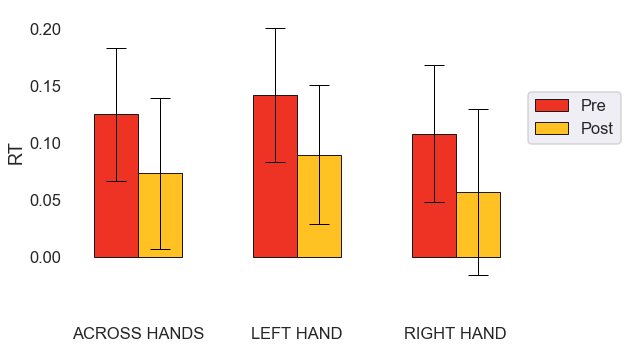

In [106]:
width = 0.25 
error_kw = {'capsize': 10, 'capthick': 1, 'ecolor': 'black','linewidth': 1}
    
# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

plt.bar(0.55, AwSplit[(AwSplit['SESSION']==1) & (AwSplit['AW_GROUP']=="High")]['RT_LOG'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0, AwSplit[(AwSplit['SESSION']==1) & (AwSplit['AW_GROUP']=="High")]['RT_LOG'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(0.8, AwSplit[(AwSplit['SESSION']==2) & (AwSplit['AW_GROUP']=="High")]['RT_LOG'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, AwSplit[(AwSplit['SESSION']==2) & (AwSplit['AW_GROUP']=="High")]['RT_LOG'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

plt.bar(1.45, AwSplit[(AwSplit['SESSION']==1) & (AwSplit['AW_GROUP']=="High") & (AwSplit['HAND']==1)]['RT_LOG'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0, AwSplit[(AwSplit['SESSION']==1) & (AwSplit['AW_GROUP']=="High") & (AwSplit['HAND']==1)]['RT_LOG'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(1.7, AwSplit[(AwSplit['SESSION']==2) & (AwSplit['AW_GROUP']=="High") & (AwSplit['HAND']==1)]['RT_LOG'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, AwSplit[(AwSplit['SESSION']==2) & (AwSplit['AW_GROUP']=="High") & (AwSplit['HAND']==1)]['RT_LOG'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

plt.bar(2.35, AwSplit[(AwSplit['SESSION']==1) & (AwSplit['AW_GROUP']=="High") & (AwSplit['HAND']==2)]['RT_LOG'].mean(), width, alpha=1, color='#EE3224', edgecolor='k', linewidth=1, yerr=np.array([0, AwSplit[(AwSplit['SESSION']==1) & (AwSplit['AW_GROUP']=="High") & (AwSplit['HAND']==2)]['RT_LOG'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 
plt.bar(2.6, AwSplit[(AwSplit['SESSION']==2) & (AwSplit['AW_GROUP']=="High") & (AwSplit['HAND']==2)]['RT_LOG'].mean(), width, alpha=1, color='#FFC222', edgecolor='k', linewidth=1, yerr=np.array([0, AwSplit[(AwSplit['SESSION']==2) & (AwSplit['AW_GROUP']=="High") & (AwSplit['HAND']==2)]['RT_LOG'].std()/sqrt(len(subjects))])[1], error_kw=error_kw) 

# Set the y axis label
ax.set_ylabel('RT')

# Set the position of the x ticks
ax.set_xticks([0.675,1.575,2.475])

# Set the labels for the x ticks
ax.set_xticklabels(["ACROSS HANDS", "LEFT HAND", "RIGHT HAND"])
ax.tick_params(axis='x', pad=30)
# Add gridline
#ax.grid(color='k', linestyle='--', linewidth=0.5, axis ='y', which="both")
ax.set_facecolor('xkcd:white')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(['Pre', 'Post'],loc='lower left', bbox_to_anchor=(1, 0.5))
    
plt.show()